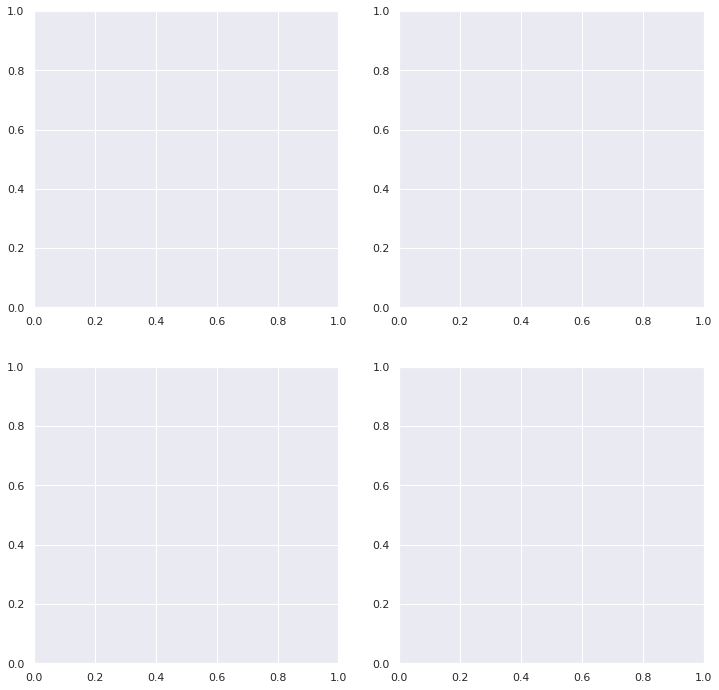

In [31]:
# Imports
import os

import pandas as pd
from matplotlib.ticker import PercentFormatter
from matplotlib import pyplot as plt

from switch_model.tools.graph.main import GraphTools, Scenario

# Define folders
rel_path_base = "../../../../switch_runs/ldes_runs"
output_file_name="Figure 1"
root_path = os.path.normpath(os.path.join(os.getcwd(), rel_path_base))
graph_dir=os.path.join(root_path,"LDES_paper_graphs")
output_path=os.path.join(graph_dir, output_file_name)
get_rel_path = lambda ext: os.path.join(rel_path_base, ext)

# Define scenarios
baseline = Scenario(get_rel_path("1342"), name=1.94)
min_2 = Scenario(get_rel_path("M7"), name=2)
min_4 = Scenario(get_rel_path("M6"), name=4)
min_8 = Scenario(get_rel_path("M5"), name=8)
min_16 = Scenario(get_rel_path("M4"), name=16)
min_32 = Scenario(get_rel_path("M3"), name=32)
min_64 = Scenario(get_rel_path("M2"), name=64)
scenarios = [baseline, min_2, min_4, min_8, min_16, min_32, min_64]

# Define constants
STORAGE_CAPACITY_LEGEND = "Storage Capacity (TWh)"
X_LABEL = "WECC-wide Storage Capacity (TWh)"

# Prepare graph tools
tools = GraphTools(scenarios=scenarios, graph_dir=graph_dir)
tools.pre_graphing(multi_scenario=True, name=output_file_name)

# Specify formatting and get figure
tools.plt.rcParams['font.family'] = 'sans-serif'
figure_size = (12, 12)
fig = tools.get_figure(size=figure_size)

# Define save() function to use in charts
def save():
    fig.savefig(output_path, bbox_inches="tight")
    print("Saved figure to " + output_path)
    return fig

# Define axes
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)  # , sharey=ax1)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)

Saved figure to /data/home/machstg/switch_runs/ldes_runs/LDES_paper_graphs/Figure 1


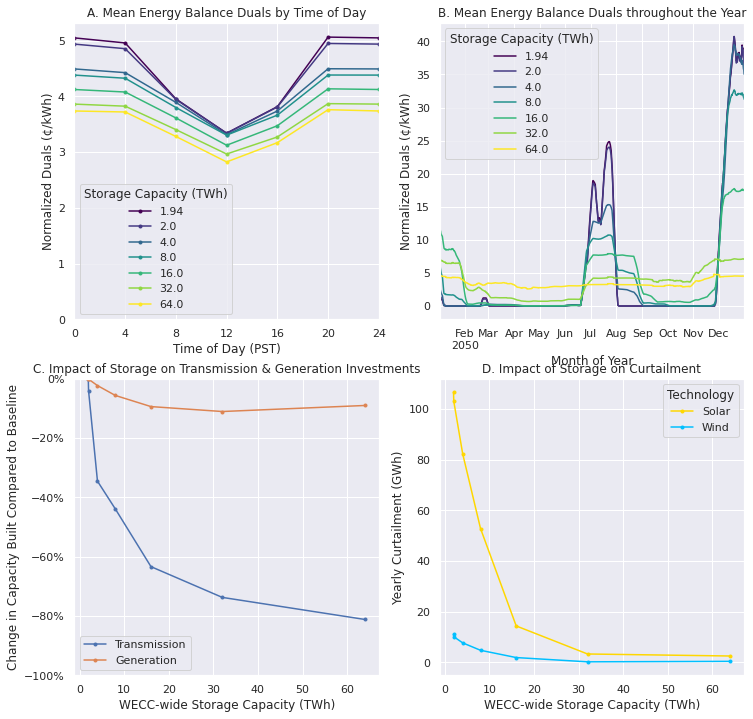

In [43]:
ax=ax1
ax.clear()
ax.tick_params(top=False, bottom=False, right=False, left=False, which="both")

df = tools.get_dataframe('load_balance.csv', usecols=[
    "timestamp",
    "normalized_energy_balance_duals_dollar_per_mwh",
    "scenario_name"
]).rename(columns={"normalized_energy_balance_duals_dollar_per_mwh": "value"})
# df = df[df["scenario_name"] != "1.94"]
df = tools.transform.timestamp(df)
df = df.groupby(["scenario_name", "hour"], as_index=False)["value"].mean()
df = df.pivot(index="hour", columns="scenario_name", values="value")
df = df.rename_axis(STORAGE_CAPACITY_LEGEND, axis=1)
df.loc[24] = df.loc[0]
df *= 0.1 # Convert from $/MWh to cents/kWh
df.plot(ax=ax, colormap="viridis", xlabel="Time of Day (PST)", marker=".",
        ylabel=u"Normalized Duals (\xa2/kWh)")
ax.set_xlim(0, 24)
ax.set_ylim(0, df.max().max() * 1.05)
ax.set_title("A. Mean Energy Balance Duals by Time of Day")
ax.set_xticks([0, 4, 8, 12, 16, 20, 24])
save()

Saved figure to /data/home/machstg/switch_runs/ldes_runs/LDES_paper_graphs/Figure 1


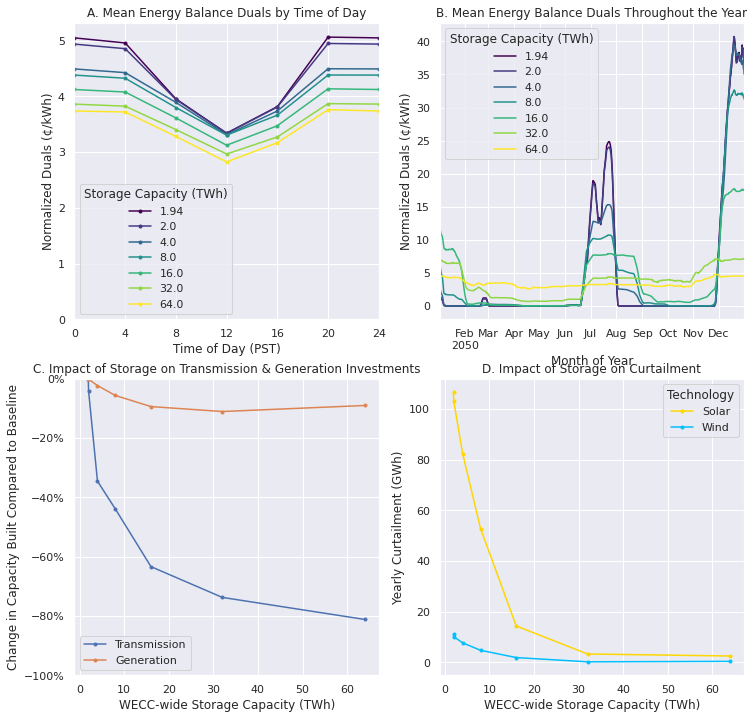

In [44]:
ax = ax2
ax.clear()
ax.tick_params(top=False, bottom=False, right=False, left=False, which="both")

df = tools.get_dataframe('load_balance.csv', usecols=[
        "timestamp",
        "normalized_energy_balance_duals_dollar_per_mwh",
        "scenario_name"
]).rename(columns={"normalized_energy_balance_duals_dollar_per_mwh": "value"})
# df = df[df["scenario_name"] != "1.94"]
df = df.groupby(["scenario_name", "timestamp"], as_index=False).mean()
df = tools.transform.timestamp(df)
df = df.set_index("datetime")
df = df.groupby("scenario_name", as_index=False).rolling("7D", center=True)["value"].mean()
df = df.unstack("scenario_name").rename_axis("Storage Capacity (TWh)", axis=1)
# Convert from $/MWh to cents/kWh
df *= 0.1
df.plot(ax=ax, colormap="viridis", xlabel="Month of Year", ylabel=u"Normalized Duals (\xa2/kWh)")
ax.set_title("B. Mean Energy Balance Duals Throughout the Year")


save()

Saved figure to /data/home/machstg/switch_runs/ldes_runs/LDES_paper_graphs/Figure 1


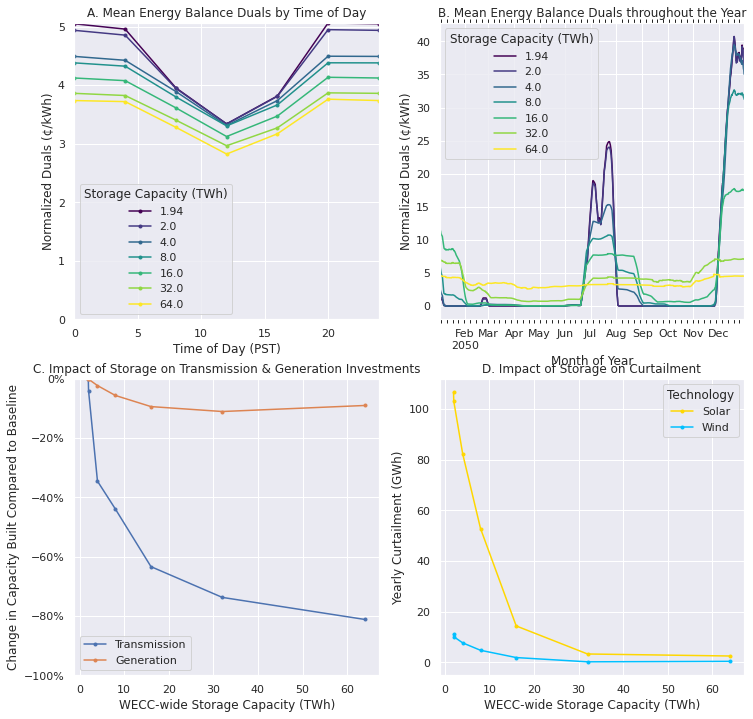

In [39]:
ax=ax3
ax.clear()
ax.tick_params(top=False, bottom=False, right=False, left=False, which="both")

# Calculate transmission
tx = tools.get_dataframe("transmission.csv", usecols=["BuildTx", "trans_length_km", "scenario_name"], convert_dot_to_na=True).fillna(0)
tx["BuildTx"] *= tx["trans_length_km"]
tx = tx.groupby("scenario_name")["BuildTx"].sum().rename("Transmission")

# Get new buildout
buildout = tools.get_dataframe("BuildGen.csv").rename(columns={"GEN_BLD_YRS_1": "GENERATION_PROJECT"})
# Keep only latest year
buildout = buildout[buildout["GEN_BLD_YRS_2"] == 2050]
# Merge with projects to get gen_type
projects = tools.get_dataframe("generation_projects_info.csv", from_inputs=True, usecols=[
    "GENERATION_PROJECT", "gen_tech", "gen_energy_source", "scenario_name"
])
buildout = buildout.merge(
    projects,
    on=["GENERATION_PROJECT", "scenario_name"],
    validate="one_to_one",
    how="left"
)
del projects
buildout = tools.transform.gen_type(buildout)
# Filter out storage since it's not considered generation
buildout = buildout[buildout["gen_type"] != "Storage"]
# Sum accross the entire scenario
buildout = buildout.groupby("scenario_name")["BuildGen"].sum().rename("Generation")

# Merge into same dataframe
df = pd.concat([tx, buildout], axis=1)

# Convert to percent against baseline
df = (df / df.iloc[0] - 1) * 100

# Plot
df.plot(ax=ax, marker=".")
ax.set_ylabel("Change in Capacity Built Compared to Baseline")
ax.yaxis.set_major_formatter(PercentFormatter())
ax.set_xlabel(X_LABEL)
ax.set_title("C. Impact of Storage on Transmission & Generation Investments")
ax.set_ylim(-100, 0)


save()

Saved figure to /data/home/machstg/switch_runs/ldes_runs/LDES_paper_graphs/Figure 1


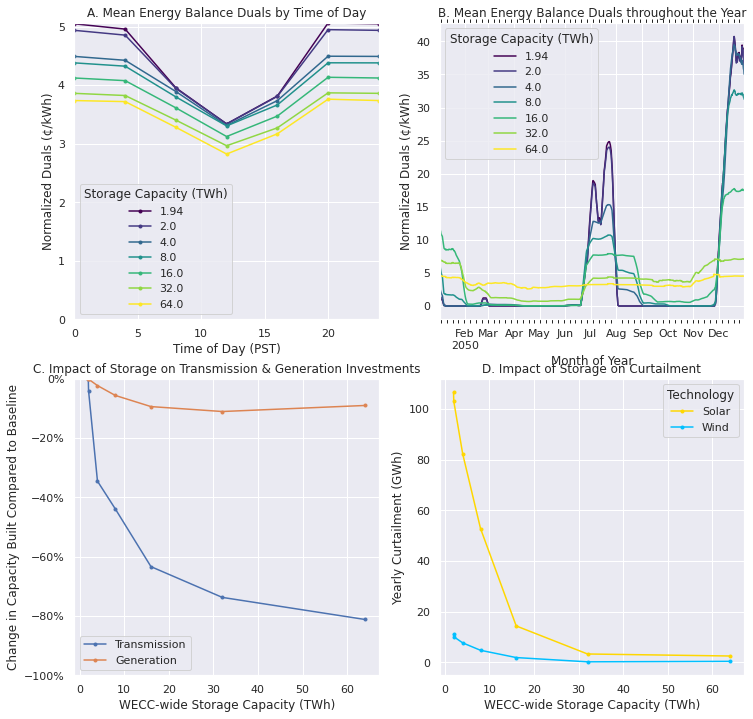

In [35]:
# Read dispatch.csv
ax=ax4
ax.clear()
df = tools.get_dataframe(
    'dispatch.csv',
    usecols=["gen_tech", "gen_energy_source", "Curtailment_MW", "is_renewable", "tp_weight_in_year_hrs",
             "scenario_name"],
    na_filter=False,  # For performance
)
# Keep only renewable
df = df[df["is_renewable"]]
# Add the gen_type column
df = tools.transform.gen_type(df)
# Convert to GW
df["value"] = df["Curtailment_MW"] * df["tp_weight_in_year_hrs"] / 1000
df = df.groupby(["scenario_name", "gen_type"], as_index=False).value.sum()
df = df.pivot(index="scenario_name", columns="gen_type", values="value")
df /= 1000
df = df.rename_axis("Technology", axis=1)
df.plot(
    ax=ax,
    color=tools.get_colors(),
    marker="."
)
ax.set_ylabel("Yearly Curtailment (GWh)")
ax.set_xlabel(X_LABEL)
ax.set_title("D. Impact of Storage on Curtailment")
ax.tick_params(top=False, bottom=False, right=False, left=False)


save()